# Texas Hold'em Hand Evaluator, preflop hand statistics, and odd calculator

#### Abstract: ####

This post is a personal exploration of the Texas Hold'em Poker game.
It is based on [SpecialK](http://specialk-coding.blogspot.fr/2010/04/texas-holdem-7-card-evaluator_23.html)'s very elegant, a bit lucky (see why below), and extremely efficient hand evaluator algorithm.
I am using the IPython notebook as an experiment, and all the code is available in this [github repo](tbd).

#### Algorithm ####
Here is a brief description of the algorithm.

But before I get into the details, I want to show the image it evoked in my mind when I first read it, as elegant and fast as it immediately appeared.

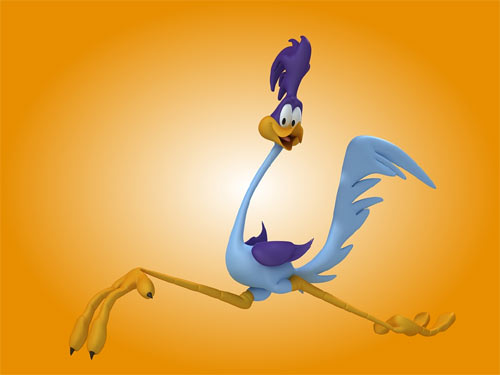

In [2]:
from IPython.display import Image
Image('img/roadrunner.jpeg')

The objective is to evaluate the rank of a full 7 card poker hand: 2 card in the hand, 5 on the board.
Each card has a face, from 0 to 12 (from 2 to Ace), and a suit, from 0 to 3 (spades, hearts, diamonds, clubs). Each face and suit is associated to 2 integers, the first one will be used if the hand is not a flush (card face key), the second if the hand is a flush (card flush key). Each suit is associated to an integer (suit key).

Two sets of keys are created
    for a five card hand
    for a seven card hand

For a five card hand:
    The suit keys are such that any 2 sums of different 7 suit keys (corresponding to the 7 cards of the evaluated hand) are different.
    The face keys are such that any 2 sums of 5 face keys, each present at most 4 times in the sum, are different.
    The flush keys are such that any 2 sums of 5 flush keys, each present at most once in the sum, are different.

For a seven card hand:
    The same suit keys as determined for five card hands are used.
    The face keys are such that any 2 sums of 7 face keys, each present at most 4 times in the sum, are different.
    The flush keys are such that any 2 sums of 5 to 7 flush keys, each present at most once in the sum, are different.

ough so there is no need to explore further.

For suit keys, an exhaustive search is feasible. The best result is [0, 1, 29, 37] for [spades, hearts, diamonds, clubs].
The flush keys and face keys are determined by brute force, through a lexicographic search: Solve for n keys, then start from this solution to try and determine the solution for n+1 keys, all the way up to 13.
It takes less than a few seconds to find valid keys in most cases, but several hours to find valid face keys for seven card hands. The keys found by this method are small enough (see below) so there is no need to dig further. 


The properties of the suit/face/flush keys are such that a 5 (resp. 7) card hand can be uniquely associated to a set of 2 keys, (i) the sum of the suit keys, (ii-1) the sum of the face keys if the hand is not a flush or straight flush, or (ii-2) the sum of the flush keys if the hand is a flush or straight flush.

Next step is to construct lookup tables for five hand hand cards:
    table of hand ranks (except flush and straight flush) indexed by sum of face keys.
    table of hand ranks (exclusively flush and straight flush) indexed by sum of flush keys.

and for seven hand cards:
    table of flush suit indexed by sum of suit keys.
    table of hand ranks (except flush and straight flush) indexed by sum of face keys.
    table of hand ranks (exclusively flush and straight flush) indexed by sum of flush keys.

The five hand card tables are constructed by going through all possible 5 card hands.

Based on these precalculated tables, here is how the rank of a five card hand is determined.
Add up all 5 suit keys. This sum, uniquely associated to this hand, enables to determine whether the hand is a flush or not.
If it is not a flush, add up all 5 face keys. By construction, the sum of the 5 face keys is uniquely associated to this hand. Look up the sum of the face keys in the face key table and read the hand rank.
If it is a flush, add up all 5 flush keys. By construction, the sum of the flush keys is uniquely associated to this hand. Look up the sum of the flush keys in the flush key table and read the hand rank.

The seven hand card tables are constructed by going through all possible 7 card hands, and evaluating each as the best among the 21 candidate 5 card hands, using the five card hand evaluator thus created.

Based on these precalculated tables, here is how the rank of a seven card hand is determined.
Add up all 7 suit keys. This sum, uniquely associated to this hand, enables to determine whether the hand is a flush or not.
If it is not a flush, add up all 7 face keys. By construction, the sum of the 7 face keys is uniquely associated to this hand. Look up the sum of the face keys in the face key table and read the hand rank.
If it is a flush, lookup the flush suit, then add up all flush keys (5, 6, or 7 depending of how many cards are the same suit). By construction, the sum of the flush keys is uniquely associated to this hand. Look up the sum of the flush keys in the flush key table and read the hand rank.

After the construction phase, only the seven card hand evaluator will be used. 

Let us now examine the keys.  
2^8 < 7 x the largest suit key < 2^9  
2^22 < 4 x the largest face key + 3 x the second largest face key < 2^23  
(The flush keys are significantly smaller than the face key, which is unsurprising given the much stronger constraint applied to the face keys)  
So it is possible to encode and process a seven card hand within 32 bits i.e. a machine integer.  
There is the magic and the unbelievable luck of this algorithm, I would even say the divine touch !

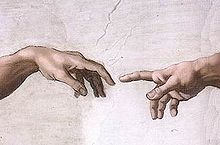

In [3]:
Image('img/220px-Hands_of_God_and_Adam.jpg')

Practically, the information for each card is encoded as follows:
    the card face key contains the suit key (9 less significant bits) and the face key (24 most significant bits)
    the card flush key is the flush key
    
Based on this convention, we can clarify further how the seven card hand evaluator works:
(1) sum the 7 card keys
(2) extract the sum of the suit keys using a bit mask/shift
(3) if the hand is not a flush, extract sum of the face keys using a bit mask/shift
    then lookup the hand rank
(4) if the hand is a flush, determine which card participate in the flush, and add the card flush key of all participants
    then lookup the hand rank


The algo is very efficient:
If the hand is not a flush (97.11% probability) the method determines the hand rank in 6 additions, 2 bit mask/shift, and 2 table lookups.
If the hand is a flush (2.88% probability), add 7 tests and 7 additions.
All operations on 32 bit integers (NB: unsigned for the hand key to negative sum).


The flip side of this speed is that the algo needs a large table, essentially empty, in memory: 0.63% of the face rank table is non zero. But is can be store efficiently as a sparse array.

Below I compute and display the main results.  
Read the code to delve into the details

In [4]:
%matplotlib inline 

import os
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import itertools as it
import cPickle
from jinja2 import Environment
from IPython.display import HTML, display, Math
from timeit import default_timer as timer

import EvalKeys as keys
import EvalFive, EvalSeven, EvalGenerateHands, EvalAnalysis

np.set_printoptions(linewidth=250)
np.set_printoptions(threshold=100)
np.set_printoptions(edgeitems=5)
np.set_printoptions(suppress=True)

pd.set_option('display.height', 100)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 500)
# pd.describe_option('display')



---------------EvalFive Tables loaded from disk
sparse_flush_rank_five loaded from file Tables/sparse_flush_rank_five.csv
sparse_face_rank_five loaded from file Tables/sparse_face_rank_five.csv
hand_faces loaded from file Tables/hand_faces.txt
hand_type loaded from file Tables/hand_type.txt

--------------- EvalSeven.load_tables
sparse_flush_rank_seven loaded from file Tables/sparse_flush_rank_seven.csv
sparse_face_rank_seven loaded from file Tables/sparse_face_rank_seven.csv
flush_suit loaded from file Tables/flush_suit.txt
height has been deprecated.



/Users/Olivier/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
keys.show_keys()


--------------- EvalKeys
NB_FACE = 13
NB_SUIT = 4
DECK_SIZE = 52
SUIT_MASK = 511
SUIT_BIT_SHIFT = 9
SUIT_KEY = 
[ 0  1 29 37]
FLUSH_KEY_FIVE = 
[   0    1    2    4    8   16   32   56  104  192  352  672 1288]
FACE_KEY_FIVE = 
[    0     1     5    22    94   312   992  2422  5624 12522 19998 43258 79415]
FLUSH_KEY_SEVEN = 
[   1    2    4    8   16   32   64  128  240  464  896 1728 3328]
FACE_KEY_SEVEN = 
[      0       1       5      22      98     453    2031    8698   22854   83661  262349  636345 1479181]
CARD_SUIT = 
[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
CARD_FACE = 
[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11 12 12 12 12]
CARD_FLUSH_KEY = 
[   1    1    1    1    2    2    2    2    4    4    4    4    8    8    8    8   16   16   16   16   32   32   32   32   64   64   64   64  128  128  128  128  240  240  2

In [6]:
EvalFive.compute_tables()
EvalFive.test()


--------------- start EvalFive.compute_tables
start High Card
start One Pair
start Two Pairs
start Three of a Kind
start Low Straight
start Usual Straight
start Flush
start Full House
start Four of a Kind
start Low Straight Flush
start Usual Straight Flush
compute_tables time =   0.0233 s
--------------- end EvalFive.compute_tables

--------------- start EvalFive.test
-------- EvalFive tables
flush_rank = 
[  15   23   27   29   30 ..., 2512 2520 2536 2560 2608]
[7453 5863 5864 5865 5866 ..., 7136 7137 7138 7139 7461]
nb of nonzero elements = 1287
face_rank = 
[     1      2      3      4      5 ..., 323284 324761 330182 337658 360918]
[7296 7140 7152 7308 7297 ..., 7448 7295 7449 7450 7451]
nb of nonzero elements = 1287
-------- EvalFive getFiveRank_ getSevenRank_ evaluators sample runs
array_five_cards=
[[21 33 24 22 39]
 [51 38 14 36 17]
 [45  8 48 34  5]
 [13 37 33 20 35]
 [31 26 50 16 49]
 [28 24 25 29  2]
 [41 13 28 25 16]
 [20 36  7 42 43]
 [38 42  8 22 44]
 [32  3 18  5 42]]
f

In [7]:
EvalSeven.compute_tables()
EvalSeven.test()


--------------- start EvalSeven.compute_tables
start face_rank
start flush_rank: 7 cards
start flush_rank: 6 cards
start flush_rank: 5 cards
start flush_suit
compute_tables time =   5.2879 s
--------------- end EvalSeven.compute_tables

--------------- start EvalSeven.test
-------- EvalSeven tables
flush_rank = 
[  31   47   55   59   61 ..., 6788 6792 6800 6816 6848]
[7453 5863 5864 5865 5866 ..., 7461 7461 7461 7461 7461]
nb of nonzero elements = 4719
face_rank = 
[      3       4       7       8       9 ..., 7198112 7212268 7273075 7451763 7825759]
[7296 7308 7297 7152 7309 ..., 7451 7451 7451 7451 7451]
nb of nonzero elements = 49205
flush_suit = 
[ 0  0  0 -1 -1 ..., -2 -2 -2 -2  3]
nb of elements different from -2 = 120
-------- EvalSeven getSevenRank_ evaluators sample runs
array_seven_cards=
[[21 33 24 22 39 37 47]
 [51 38 14 36 17  6 22]
 [45  8 48 34  5 21 42]
 [13 37 33 20 35 49  2]
 [31 26 50 16 49  9 27]
 [28 24 25 29  2 36 14]
 [41 13 28 25 16 31 17]
 [20 36  7 42 43  3 

### Below is the representation of the 52 deck cards.

In [8]:
import PIL
card_files = [[os.path.join('Cards','Full', str(1+s+4*f)+'.png')
                for f in range(13)]
                for s in range(4)]

jinja_template = """
<table style="border:0px solid black;">
{% for row in array %}
    <tr style="border:0px solid black;">
    {% for col in row %}
        <td style="background-color:white;
                    border-collapse:collapse;
                    text-align:center;
                    border:0px solid black;">
            <img border="10" src="files/{{ col }}" alt="N/A">
        </td>
    {% endfor %}
    </tr>
{% endfor %}
 </table>"""
HTML_content = Environment().from_string(jinja_template).render(array=card_files)
HTML(HTML_content)

,,,,,,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,
,,,,,,,,,,,,


### Below are all possible five card hands stored in a dataframe.

In [9]:
t0 = timer()
df_hand_five = EvalAnalysis.create_df_hand_five()
t1 = timer()
print 'df_hand_five time = {:4.2f} s'.format(t1-t0)

df_hand_five time = 0.35 s


In [10]:
HTML('''<style>
    .df tbody tr:last-child { background-color: #FFAAAA; }
    .df { font-size: 12px; }
    </style>''' + df_hand_five.to_html(classes='df'))

,HandType,NbHands,MinRank,MaxRank,NbOccurence,ProbaExact,Odd,ProbaApprox,CumulativeProba
0,Straight Flush,10,7452,7461,40,1/64974,64974,1.53908e-05,1.53908e-05
1,Four of a Kind,156,7296,7451,624,1/4165,4165,0.000240096,0.000255487
2,Full House,156,7140,7295,3744,6/4165,694.167,0.00144058,0.00169606
3,Flush,1277,5863,7139,5108,1277/649740,508.802,0.0019654,0.00366146
4,Straight,10,5853,5862,10200,5/1274,254.8,0.00392465,0.00758611
5,Three of a Kind,858,4995,5852,54912,88/4165,47.3295,0.0211285,0.0287146
6,Two Pairs,858,4137,4994,123552,198/4165,21.0354,0.047539,0.0762536
7,One Pair,2860,1277,4136,1098240,352/833,2.36648,0.422569,0.498823
8,High Card,1277,0,1276,1302540,1277/2548,1.9953,0.501177,1
9,All,7462,0,7461,2598960,1,1,1,NaN


### Below are the exact formulae for the number of five card hands by type. See [wikipedia](http://en.wikipedia.org/wiki/Poker_probability) for the calculations.

In [11]:
for k, h in enumerate(EvalAnalysis.nb_occurence_formula_hand_five):
    print '{} : '.format(h[0])
    display(Math(h[1]))
    print

Straight Flush : 


<IPython.core.display.Math object>


Four of a Kind : 


<IPython.core.display.Math object>


Full House : 


<IPython.core.display.Math object>


Flush : 


<IPython.core.display.Math object>


Straight : 


<IPython.core.display.Math object>


Three of a Kind : 


<IPython.core.display.Math object>


Two Pairs : 


<IPython.core.display.Math object>


One Pair : 


<IPython.core.display.Math object>


High Card : 


<IPython.core.display.Math object>


All : 


<IPython.core.display.Math object>

### Below are all the possible seven card hands stored in a dataframe.  
Somewhat counterintuitively, there are less than five hand cards.  
On closer examination, this is explained by the fact that the 2 extra cards cannot be ignored and tend to increase its value.  

In [12]:
t0 = timer()
df_hand_seven = EvalAnalysis.create_df_hand_seven()
t1 = timer()
print 'df_hand_seven time = {:4.2f} s'.format(t1-t0)

df_hand_seven time = 10.62 s


In [13]:
HTML('''<style>
    .df tbody tr:last-child { background-color: #FFAAAA; }
    .df tbody { font-size: 12px; }
    </style>''' + df_hand_seven.to_html(classes='df'))

,HandType,NbHands_5,NbHands_7,MinRank_5,MinRank_7,MaxRank_5,MaxRank_7,NbOccurence,ProbaExact,Odd,ProbaApprox,CumulativeProba
0,Straight Flush,10,10,7452,7452,7461,7461,41584,113/363545,3217.21,0.000310828,0.000310828
1,Four of a Kind,156,156,7296,7296,7451,7451,224848,1/595,595,0.00168067,0.0019915
2,Full House,156,156,7140,7140,7295,7295,3473184,726/27965,38.5193,0.025961,0.0279525
3,Flush,1277,1277,5863,5863,7139,7139,4047644,1011911/33446140,33.0525,0.0302549,0.0582075
4,Straight,10,10,5853,5853,5862,5862,6180020,44143/955604,21.6479,0.0461938,0.104401
5,Three of a Kind,858,575,4995,5003,5852,5852,6461620,14047/290836,20.7045,0.0482987,0.1527
6,Two Pairs,858,763,4137,4140,4994,4994,31433400,785835/3344614,4.25613,0.234955,0.387655
7,One Pair,2860,1470,1277,1295,4136,4136,58627800,4455/10166,2.28193,0.438225,0.825881
8,High Card,1277,407,0,48,1276,1276,23294460,166389/955604,5.74319,0.174119,1
9,All,7462,4824,0,48,7461,7461,133784560,1,1,1,NaN


### Below are the exact formulae for the number of seven hands by type. See [wikipedia](http://en.wikipedia.org/wiki/Poker_probability) for the calculations.

In [14]:
for k, h in enumerate(EvalAnalysis.nb_occurence_formula_hand_seven):
    print '{} : '.format(h[0])
    display(Math(h[1]))
    print

Straight Flush : 


<IPython.core.display.Math object>


Four of a Kind : 


<IPython.core.display.Math object>


Full House - 1 Triple, 1 Pair, 2 Kickers : 


<IPython.core.display.Math object>


Full House - 1 Triple, 2 Pairs : 


<IPython.core.display.Math object>


Full House - 2 Triples, 1 Kicker : 


<IPython.core.display.Math object>


Flush - 7 cards same suit : 


<IPython.core.display.Math object>


Flush - 6 cards same suit : 


<IPython.core.display.Math object>


Flush - 5 cards same suit : 


<IPython.core.display.Math object>


Straight - 7 distinct faces : 


<IPython.core.display.Math object>


Straight - 6 distinct faces : 


<IPython.core.display.Math object>


Straight - 5 distinct faces, 1 Triple : 


<IPython.core.display.Math object>


Straight - 5 distinct faces, 2 Triples : 


<IPython.core.display.Math object>


Three of a Kind : 


<IPython.core.display.Math object>


Two Pairs - 2 Pairs, 3 Kickers : 


<IPython.core.display.Math object>


Two Pairs - 3 Pairs, 1 Kicker : 


<IPython.core.display.Math object>


One Pair : 


<IPython.core.display.Math object>


High Card : 


<IPython.core.display.Math object>


All : 


<IPython.core.display.Math object>

There are 169 different possible pre flop hands:
    C(13,2) = 78 suited hands
    C(13,2) = 78 offsuited hands, excluding pairs
    13 pairs

In [15]:
face = EvalAnalysis.face_symbol
choice = EvalAnalysis.choice
all_preflop_hands = EvalAnalysis.all_preflop_hands
pairs = [[{'hand' : face[i]+face[j]+choice(i, j, ['o', 's', 'o']),
           'color' : choice(i, j, ['#8dd3c7', '#ffffb3', '#bebada'])}
                for i in range(len(face))[::-1]]
                for j in range(len(face))[::-1]]

jinja_template = """
<table>
{% for row in array %}
    <tr>
    {% for col in row %}
        <td style="background-color:{{ col.color }};
                    color:black;
                    border-collapse:collapse;
                    text-align:center;
                    font-family:Arial;
                    border:1px solid black;">
                    {{ col.hand }}</td>
    {% endfor %}
    </tr>
{% endfor %}
 </table>"""
HTML_content = Environment().from_string(jinja_template).render(array=pairs)

print 'nb of preflop hands = {}'.format(len(all_preflop_hands))
HTML(HTML_content)

nb of preflop hands = 169


AAo,KAs,QAs,JAs,TAs,9As,8As,7As,6As,5As,4As,3As,2As
AKo,KKo,QKs,JKs,TKs,9Ks,8Ks,7Ks,6Ks,5Ks,4Ks,3Ks,2Ks
AQo,KQo,QQo,JQs,TQs,9Qs,8Qs,7Qs,6Qs,5Qs,4Qs,3Qs,2Qs
AJo,KJo,QJo,JJo,TJs,9Js,8Js,7Js,6Js,5Js,4Js,3Js,2Js
ATo,KTo,QTo,JTo,TTo,9Ts,8Ts,7Ts,6Ts,5Ts,4Ts,3Ts,2Ts
A9o,K9o,Q9o,J9o,T9o,99o,89s,79s,69s,59s,49s,39s,29s
A8o,K8o,Q8o,J8o,T8o,98o,88o,78s,68s,58s,48s,38s,28s
A7o,K7o,Q7o,J7o,T7o,97o,87o,77o,67s,57s,47s,37s,27s
A6o,K6o,Q6o,J6o,T6o,96o,86o,76o,66o,56s,46s,36s,26s
A5o,K5o,Q5o,J5o,T5o,95o,85o,75o,65o,55o,45s,35s,25s
A4o,K4o,Q4o,J4o,T4o,94o,84o,74o,64o,54o,44o,34s,24s


For a given pre flop hand, there are C(50,5) = 2,118,760 different tables. Assuming each set of table cards is equally likely, i.e. neglecting the other players' cards, we compute the distribution of hand ranks for a given pre flop hand.


In [16]:
df_preflop_hand_distrib = EvalAnalysis.create_df_preflop_hand_distrib()


--------------- start create_df_preflop_hand_distrib
all preflop hands = 
start = ['AAo', 'AKs', 'AQs', 'AJs', 'ATs', 'A9s', 'A8s', 'A7s', 'A6s', 'A5s']
end = ['2Jo', '2To', '29o', '28o', '27o', '26o', '25o', '24o', '23o', '22o']
nb of elements = 169

hand rank distribution for all preflop hands
k = 170 / 170
df_preflop_hand_distrib time =  26.9545 s
--------------- end create_df_preflop_hand_distrib


### Below is displayed a fraction of the distribution of hand ranks per preflop hand.

In [17]:
#df_preflop_hand_distrib = pd.read_pickle(os.path.join('Tables', 'df_preflop_hand_distrib.pd'))
HTML('''<style>
    .df1 { font-size: 11px; }
    </style>''' + df_preflop_hand_distrib.ix[:, :30].tail(5).to_html(classes='df1'))

,NoHand,AAo,AKs,AQs,AJs,ATs,A9s,A8s,A7s,A6s,A5s,A4s,A3s,A2s,KAo,KKo,KQs,KJs,KTs,K9s,K8s,K7s,K6s,K5s,K4s,K3s,K2s,QAo,QKo,QQo
7457,4140,4,4,4,3,48,48,48,48,48,4,4,4,4,4,4,4,3,48,48,48,48,48,4,4,4,4,4,4,4
7458,4140,4,4,3,48,48,48,48,48,4,4,4,4,4,4,4,3,48,48,48,48,48,4,4,4,4,4,3,3,2
7459,4140,4,3,48,48,48,48,48,4,4,4,4,4,4,3,2,3,3,3,3,3,3,3,3,3,3,3,48,47,92
7460,4140,2,3,3,3,3,3,3,3,3,3,3,3,3,47,92,1038,1038,1038,1038,48,48,48,48,48,48,48,47,92,92
7461,4324,94,1084,1084,1084,1084,49,49,49,49,49,49,49,49,94,94,1084,1084,1084,49,49,49,49,49,49,49,49,94,94,94


### Below is plotted the distribution of hand ranks for one particular preflop hand, compared with the native distribution (all preflop hands being equally probable).

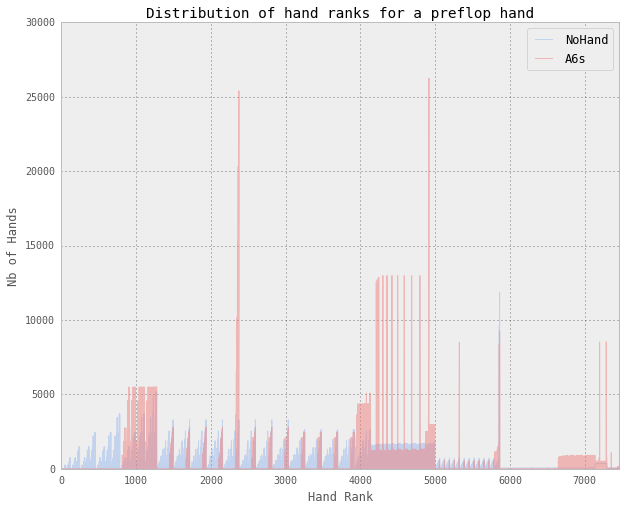

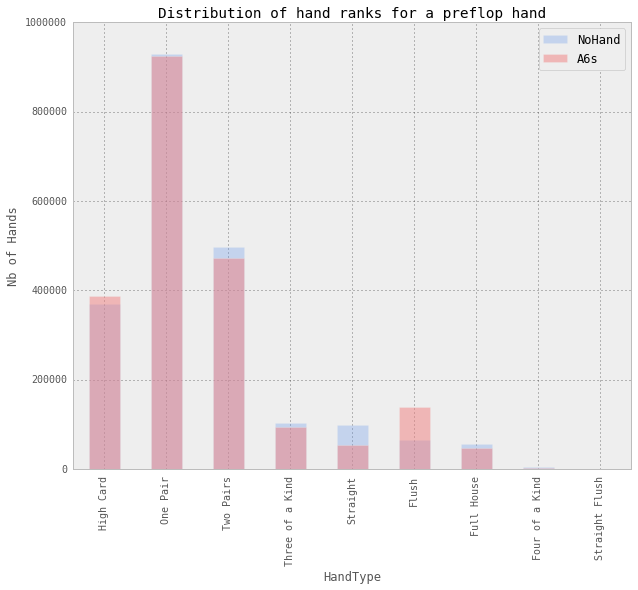

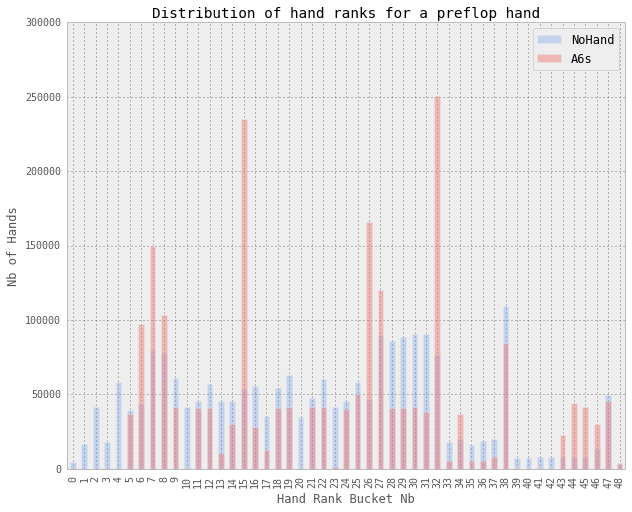

In [18]:
hand = ('A5s')
idx = EvalAnalysis.preflop_hand_str_order(hand, return_index=True)
s = df_preflop_hand_distrib.ix[:, idx]
s_ref = df_preflop_hand_distrib.ix[:, 0]
s_ref = s_ref*1.0*s.sum()/s_ref.sum()


# exact plot 
fig=pl.figure(figsize=(10, 8))
s_ref.plot(color="#6495ED", alpha=0.3)
s.plot(color="#F08080", alpha=0.5)
pl.title('Distribution of hand ranks for a preflop hand')
pl.xlabel('Hand Rank')
pl.ylabel('Nb of Hands')
pl.legend()
pl.show()


# plot by hand type buckets
bins = np.r_[df_hand_five['MinRank'].values[:-1][::-1],
             df_hand_five['MaxRank'].values[0]+1]

s_bin = np.zeros([bins.size-1], dtype=np.float32)
for k in range(bins.size-1):
	s_bin[k] = s[bins[k]:bins[k+1]].sum()
s_bin = pd.Series(s_bin, index=df_hand_five['HandType'][:-1][::-1], name=s.name)

s_ref_bin = np.zeros([bins.size-1], dtype=np.float32)
for k in range(bins.size-1):
	s_ref_bin[k] = s_ref[bins[k]:bins[k+1]].sum()
s_ref_bin = pd.Series(s_ref_bin, index=df_hand_five['HandType'][:-1][::-1], name=s_ref.name)

fig=pl.figure(figsize=(10, 8))
s_ref_bin.plot(kind='bar', color="#6495ED", alpha=0.3)
s_bin.plot(kind='bar', color="#F08080", alpha=0.5)
pl.title('Distribution of hand ranks for a preflop hand')
pl.ylabel('Nb of Hands')
pl.legend()
pl.show()


# plot by same sized hand rank buckets
bins_1 = np.array(np.linspace(1, 7462, 50), dtype=np.int32)

s_bin_1 = np.zeros([bins_1.size-1], dtype=np.float32)
for k in range(bins_1.size-1):
	s_bin_1[k] = s[bins_1[k]:bins_1[k+1]].sum()
s_bin_1 = pd.Series(s_bin_1, name=s.name)

s_ref_bin_1 = np.zeros([bins_1.size-1], dtype=np.float32)
for k in range(bins_1.size-1):
	s_ref_bin_1[k] = s_ref[bins_1[k]:bins_1[k+1]].sum()
s_ref_bin_1 = pd.Series(s_ref_bin_1, name=s_ref.name)

fig=pl.figure(figsize=(10, 8))
s_ref_bin_1.plot(kind='bar', color="#6495ED", alpha=0.3)
s_bin_1.plot(kind='bar', color="#F08080", alpha=0.5)
pl.title('Distribution of hand ranks for a preflop hand')
pl.xlabel('Hand Rank Bucket Nb')
pl.ylabel('Nb of Hands')
pl.legend()
pl.show()


Below is the visualisation of pre flop hand rank distributions for all preflop hands.  
[Here](http://oscar6echo.github.io/Poker2/viz/one_preflop_hand/) is the native page.  
(iframes inside the notebook often don't look as good as in native pages)

In [19]:
from IPython.display import HTML
HTML("""<div class="wrapper" style="height: 850px; overflow: hidden; padding: 0; text-align: center; width: 850px;">
<iframe scrolling="no" src="http://oscar6echo.github.io/Poker2/viz/one_preflop_hand/" 
style="-moz-transform-origin: 0 0;
-moz-transform: scale(1.0);
-o-transform-origin: 0 0;
-o-transform: scale(1.0);
-webkit-transform-origin: 0 0;
-webkit-transform: scale(1.0);
border: 0px black solid; 
height: 850px; 
overflow: hidden;
width: 850px; 
zoom: 1.0;">
</iframe>
</div>'""")

Now, instead of considering a single pre flop hand, we compare all pairs of pre flop hands.  
First we determine all possible pairs.  
Provisionally there are C(169,2)+169 = 14,365 possible pairs. But on closer inspection, for each such pair, there may be several combinations of suits in both hands. Specifically, the combinations of suits depends on whether each hand is suited/offsuited, a pair/not a pair. The exhaustive range of combinations is in the tables below.

In [20]:
all_preflop_two_hands = EvalAnalysis.all_preflop_two_hands
n = len(all_preflop_hands)
print 'nb of preflop two hands = {}'.format(EvalAnalysis.C(n, 2)+n)
(all_preflop_two_hands[:10], all_preflop_two_hands[-10:])

nb of preflop two hands = 14365


([('AAo', 'AKs'),
  ('AAo', 'AQs'),
  ('AAo', 'AJs'),
  ('AAo', 'ATs'),
  ('AAo', 'A9s'),
  ('AAo', 'A8s'),
  ('AAo', 'A7s'),
  ('AAo', 'A6s'),
  ('AAo', 'A5s'),
  ('AAo', 'A4s')],
 [('2Jo', '2Jo'),
  ('2To', '2To'),
  ('29o', '29o'),
  ('28o', '28o'),
  ('27o', '27o'),
  ('26o', '26o'),
  ('25o', '25o'),
  ('24o', '24o'),
  ('23o', '23o'),
  ('22o', '22o')])

In [21]:
pfh_combin = EvalAnalysis.pfh_combin
suit_combin = EvalAnalysis.suit_combin
suit_combin_freq = EvalAnalysis.suit_combin_freq
suit_symbol_html = EvalAnalysis.suit_symbol_html
top_row = ['']+range(8)
rng_row = range(len(pfh_combin))
rng_col = range(max([len(e) for e in suit_combin]))

jinja_template = """
<table style="border:0px;">
<tr style="border:0px; border-bottom:1px solid #999;">
    <td style="border-width:0px; border-right:1px solid #999;"></td>
    {% for col in rngcol %}
        <td style="border:0px; text-align:center;">{{ col+1 }}</td>
    {% endfor %}
</tr>
{% for row in pfhcombin %}
    {% set outer_loop = loop %}
    <tr style="border:0px;">
        <td style="border:0px; border-right:1px solid #999; width:260px; font-size:90%;">{{row}}</td>
       {% for col in suitcombin[outer_loop.index0] %}
            <td style="border:0px; width:60px;  text-align:center; font-size:90%">
            {{freq[outer_loop.index0][loop.index0]}}x[{{symbol[col[0]]}}{{symbol[col[1]]}}-{{symbol[col[2]]}}{{symbol[col[3]]}}]
            </td>
    {% endfor %}
   </tr>
{% endfor %}
</table>"""

HTML_content = Environment().from_string(jinja_template).render(toprow=top_row,
                                                            pfhcombin=pfh_combin,
                                                            suitcombin = suit_combin,
                                                            freq = suit_combin_freq,
                                                            symbol=suit_symbol_html,
                                                            rngrow=rng_row,
                                                            rngcol=rng_col)
HTML(HTML_content)

The number of suit combinations ranges from 2 to 7 depending on the pair characteristics (suited/offsuited, pair/no pair) considered. Note that these combinations represent the maximum diversity in terms of suit possibilities for a pre flop hand pair. In several cases these combinations collapse to a narrower range of possibilities. For example, 98o vs. 98o are two offsuited hands, and none is a pair. The table mentions 7 suit combinations, but because the faces overlap, 3 of these combinations disappear, or rather merge into the 4 remaining.


Below are displayed the exact statistics for the pair of preflop hands {98o, 98o}.

In [22]:
# all_preflop_two_hand_equity = create_all_preflop_two_hand_equity(verbose=False)
all_preflop_two_hand_equity = cPickle.load(
            open(os.path.join('Tables','all_preflop_two_hand_equity_full.pk'), 'rb'))

pair = ('89o', '98o')
pair_ordered = EvalAnalysis.preflop_two_hand_str_order(pair, return_index=False)
EvalAnalysis.preflop_two_hand_equity(pair_ordered, verbose=True);

preflop hands : ('89o', '89o')
suit combination #0
	8♠ 9♥ - 8♦ 9♣
	frequency = 24
	h1#wins	#ties	h2#wins
	37213	1637878	37213
	2.173%	95.653%	2.173%
suit combination #1
	8♠ 9♥ - 8♦ 9♠
	frequency = 24
	h1#wins	#ties	h2#wins
	18652	1662422	31230
	1.089%	97.087%	1.824%
suit combination #2
	8♠ 9♥ - 8♥ 9♦
	frequency = 24
	h1#wins	#ties	h2#wins
	31230	1662422	18652
	1.824%	97.087%	1.089%
suit combination #3
	8♠ 9♥ - 8♥ 9♠
	frequency = 12
	h1#wins	#ties	h2#wins
	12669	1686966	12669
	0.740%	98.520%	0.740%
preflop_two_hand_equity time =   0.5941 s


Going though all pairs of pre flop hands and suit combinations, we can determine the exact number of distinct (in terms of hand ranks) pairs of pre flop hands: 47,086. Which means the average number of suits combination for each pair of pre flop hands is 47086/14365~3.28.

Note that this takes several hours.

In [23]:
print 'number of distinct (rankwise) pairs of preflop hands = {}'.format(
            np.array([len(e) for e in all_preflop_two_hand_equity]).sum())
(all_preflop_two_hand_equity[:3], all_preflop_two_hand_equity[-3:])

number of distinct (rankwise) pairs of preflop hands = 47086


([array([[1493670,   21503,  197131,      24]], dtype=int32),
  array([[1486939,   21315,  204050,      24]], dtype=int32),
  array([[1480208,   21127,  210969,      24]], dtype=int32)],
 [array([[  36199, 1639906,   36199,      24],
         [  18365, 1663680,   30259,      24],
         [  30259, 1663680,   18365,      24],
         [  12425, 1687454,   12425,      12]], dtype=int32),
  array([[  35990, 1640324,   35990,      24],
         [  18156, 1664098,   30050,      24],
         [  30050, 1664098,   18156,      24],
         [  12216, 1687872,   12216,      12]], dtype=int32),
  array([[  35668, 1640968,   35668,      24]], dtype=int32)])

### Below are plotted the exact statistics for a pair of preflop hands in all its possible suit combinations.

suit combination #1
Hand A / Hand B =  J♠ J♥ - 5♠ A♥
frequency = 28.571 %


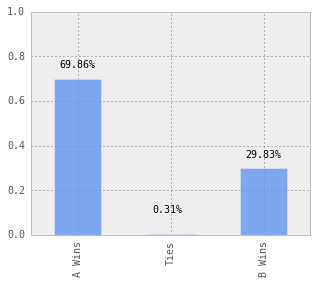

suit combination #2
Hand A / Hand B =  J♠ J♥ - 5♠ A♥
frequency = 28.571 %


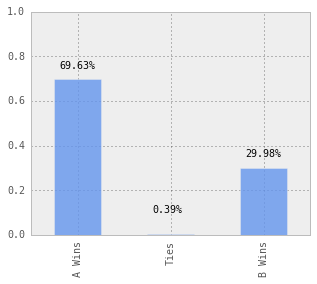

suit combination #3
Hand A / Hand B =  J♠ J♥ - 5♠ A♥
frequency = 28.571 %


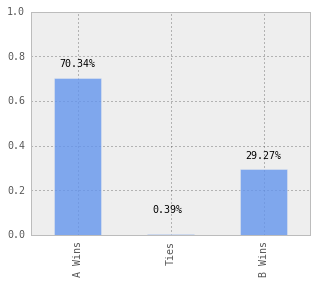

suit combination #4
Hand A / Hand B =  J♠ J♥ - 5♠ A♥
frequency = 14.286 %


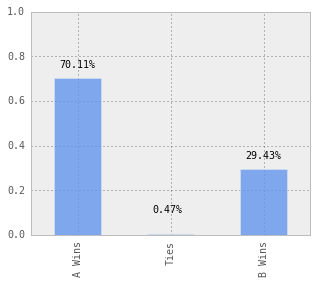

In [24]:
no_to_char = EvalAnalysis.one_hand_no_to_char
str_to_no = EvalAnalysis.hand_str_to_no
all_preflop_two_hands = EvalAnalysis.all_preflop_two_hands

pair = ('A5o', 'JJo')
p = EvalAnalysis.preflop_two_hand_str_order(pair, return_index=False)
idx = all_preflop_two_hands.index(p)
h1, h2 = p

for k in range(len(all_preflop_two_hand_equity[idx])):
    arr = all_preflop_two_hand_equity[idx][k, :3]
    arr = np.array(1.0*arr/arr.sum(), dtype=np.float32)
    freq = all_preflop_two_hand_equity[idx][:, 3]
    freq = np.array(1.0*freq/freq.sum(), dtype=np.float32)
    s = pd.Series(arr, index=['A Wins', 'Ties', 'B Wins'])
    print 'suit combination #{}'.format(1+k)
    print 'Hand A / Hand B = ', no_to_char(str_to_no(p[0]))+' - '+no_to_char(str_to_no(p[1]))
    print 'frequency = {:5.3f} %'.format(100.0*freq[k])
    
    fig=pl.figure(figsize=(5, 4))
    s.plot(kind='bar', color="#6495ED", alpha=0.8)
    for q in range(3):
        pl.text(-0.2+q, max(0.1, min(s[q]+0.05, 0.9)), '{:4.2f}%'.format(100*s[q]), fontsize=10)
    pl.ylim(0, 1)
    pl.show()


After an exhaustive comparison of all pre flop hands, we create an overview of the equity distribution for all pairs of pre flop hands, for better visualisation. In order to do so we aggregate all suit combinations and keep the frequency weighted average of the equity distribution.

In [25]:
t0 = timer()
df_equity_two_hands = EvalAnalysis.create_all_preflop_two_hand_equity_aggregate(
            all_preflop_two_hand_equity,
            save=True)
t1 = timer()
print 'df_equity_two_hands time = {:6.4f} s'.format(t1-t0)
df_equity_two_hands.head(10)

df_equity_two_hands time = 0.2380 s


,HandA,HandA_no,HandB,HandB_no,Hand1_Wins,Ties,Hand2_Wins
0,AAo,0,AKs,1,0.872316,0.012558,0.115126
1,AAo,0,AQs,2,0.868385,0.012448,0.119167
2,AAo,0,AJs,3,0.864454,0.012338,0.123208
3,AAo,0,ATs,4,0.860523,0.012229,0.127248
4,AAo,0,A9s,5,0.877756,0.013134,0.109110
5,AAo,0,A8s,6,0.873825,0.013025,0.113150
6,AAo,0,A7s,7,0.873832,0.013025,0.113143
7,AAo,0,A6s,8,0.877777,0.009087,0.113136
8,AAo,0,A5s,9,0.860558,0.012745,0.126697
9,AAo,0,A4s,10,0.864503,0.012855,0.122642


In [26]:
df_equity_two_hands.tail(10)

,HandA,HandA_no,HandB,HandB_no,Hand1_Wins,Ties,Hand2_Wins
14355,2Jo,159,2Jo,159,0.015332,0.969336,0.015332
14356,2To,160,2To,160,0.015333,0.969335,0.015333
14357,29o,161,29o,161,0.015333,0.969335,0.015333
14358,28o,162,28o,162,0.015331,0.969338,0.015331
14359,27o,163,27o,163,0.015323,0.969354,0.015323
14360,26o,164,26o,164,0.015303,0.969393,0.015303
14361,25o,165,25o,165,0.015263,0.969474,0.015263
14362,24o,166,24o,166,0.015190,0.969620,0.015190
14363,23o,167,23o,167,0.015068,0.969864,0.015068
14364,22o,168,22o,168,0.020830,0.958339,0.020830


average of all suit combinations weighted by frequency
Hand A / Hand B = JJo - 5Ao


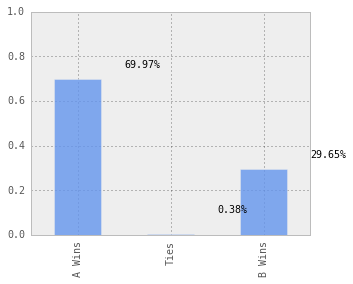

In [27]:
print 'average of all suit combinations weighted by frequency'
print 'Hand A / Hand B = {}'.format(p[0]+' - '+p[1])
s = pd.Series(data=df_equity_two_hands.ix[idx][4:].values, index=['A Wins', 'Ties', 'B Wins'])

fig=pl.figure(figsize=(5, 4))
s.plot(kind='bar', color="#6495ED", alpha=0.8)
for q in range(3):
    pl.text(0.5+q, max(0.1, min(s[q]+0.05, 0.9)), '{:4.2f}%'.format(100*s[q]), fontsize=10)
pl.ylim(0, 1)
pl.show()

### Below is the visualisation of preflop hand pairs equity distributions for all preflop hand pairs.  
[Here](http://oscar6echo.github.io/Poker2/viz/two_preflop_hand/) is the native page.

In [28]:
from IPython.display import HTML
HTML("""<div class="wrapper" style="height: 1200px; overflow: hidden; padding: 0; text-align: center; width: 850px;">
<iframe scrolling="no" src="http://oscar6echo.github.io/Poker2/viz/two_preflop_hand/" 
style="-moz-transform-origin: 0 0;
-moz-transform: scale(1.0);
-o-transform-origin: 0 0;
-o-transform: scale(1.0);
-webkit-transform-origin: 0 0;
-webkit-transform: scale(1.0);
border: 0px black solid; 
height: 1200px; 
overflow: hidden;
width: 850px; 
zoom: 1.0;">
</iframe>
</div>'""")

Computing the strenth of preflop hands when there are more than 2 players (almost always the case in practise) is intractable as the number of different games to evaluate grows to gigantic proportions very quickly.  
Below is the exact number, p being the number of opponents (from 1 to 9).

In [29]:
Math(r"""\binom{52-2(p+1))}{5}\prod_{i=1}^{p}\binom{52-2i}{2}""")

<IPython.core.display.Math object>

Fortunately the monte carlo convergence is fast and 100,000 to 200,000 random games seem enough to give the odds of the preflop hands with a 0.10% precision (more than enough in any practical context), meaning running the simulation several times generally gives the same result within the precision. Note that is only an observation and has not theoretical basis whatsoever. Anyway this fact is convenient and makes possible a practical the online odd evaluator (see further down).

Now in order to compute the table of preflop hand equity per number of opponents, I draw 300 million random games for each preflophand.

The black line is the total equity, the gray line is the total equity minus the contribution of ties to the total equity.

### Below is the visualisation of the table of preflop hand equity per number of opponents.  
[Here](http://oscar6echo.github.io/Poker2/viz/one_preflop_hand_montecarlo/) is the native page.

In [30]:
from IPython.display import HTML
HTML("""<div class="wrapper" style="height: 1000px; overflow: hidden; padding: 0; text-align: center; width: 750px;">
<iframe scrolling="no" src="http://oscar6echo.github.io/Poker2/viz/one_preflop_hand_montecarlo/" 
style="-moz-transform-origin: 0 0;
-moz-transform: scale(1.0);
-o-transform-origin: 0 0;
-o-transform: scale(1.0);
-webkit-transform-origin: 0 0;
-webkit-transform: scale(1.0);
border: 0px black solid; 
height: 1000px; 
overflow: hidden;
width: 750px; 
zoom: 1.0;">
</iframe>
</div>'""")

### Below is a Texas Hold'em odd calculator implementing in javascript the algorithm prototyped in Python in this notebook. Javascript has become fast enough to run this evaluator.  
The evaluation is exhaustive if all players cards are known, and monte carlo if only the main player's cards are known. In the latter case other player cards are randomly drawn just like the table cards. If one card of the other player cards shows then the monte carlo simulation assumes this card is determined. This is to take into account the main player 'guess' if he has one.
[Here](http://oscar6echo.github.io/Poker2/viz/game/) is the native page.

In [31]:
from IPython.display import HTML
HTML("""<div class="wrapper" style="height: 800px; overflow: hidden; padding: 0; text-align: center; width: 750px;">
<iframe scrolling="no" src="http://oscar6echo.github.io/Poker2/viz/game/" 
style="-moz-transform-origin: 0 0;
-moz-transform: scale(1.0);
-o-transform-origin: 0 0;
-o-transform: scale(1.0);
-webkit-transform-origin: 0 0;
-webkit-transform: scale(1.0);
border: 0px black solid; 
height: 800px; 
overflow: hidden;
width: 750px; 
zoom: 1.0;">
</iframe>
</div>'""")

Et voilà !  
I did this summary partly to experiment with the IPython notebook and I have to say I'm impressed.  
It is fantastically convenient. Notebooks existed before IPython, but (it seems to me) the real stroke of genius was the design decision to build it on top of modern browsers, instead of starting from scratch again. In other words, to stand on the shoulders of giants...

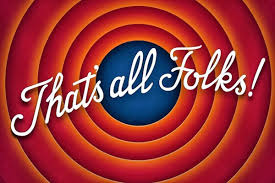

In [32]:
Image('img/thats_all_folks.jpeg')